In [1]:
import pandas as pd 
import numpy as np 


In [2]:
routes = pd.read_csv('final_domestic_routes.csv' , index_col="route")
routes

,navaid,latitude,longitude,has_one_occurrence,node,node_lat,node_long
route,,,,,,,
A201,LKN,26.758556,80.894417,False,43,26.758556,80.894417
A201,BODOG,26.026944,83.581944,False,175,25.886984,83.544722
A201,PPT,25.590417,85.089917,False,123,25.590417,85.089917
A201,MONDA,25.350556,86.437778,False,255,25.405834,86.530602
A201,BIKIK,24.779722,87.797500,False,155,24.769524,87.919802
...,...,...,...,...,...,...,...
Z303,LA,31.499722,74.400019,False,362,31.499722,74.400019
Z305,LA,31.499722,74.400019,False,362,31.499722,74.400019
Z305,ADNIM,31.813333,74.047778,True,7,31.862331,74.015913


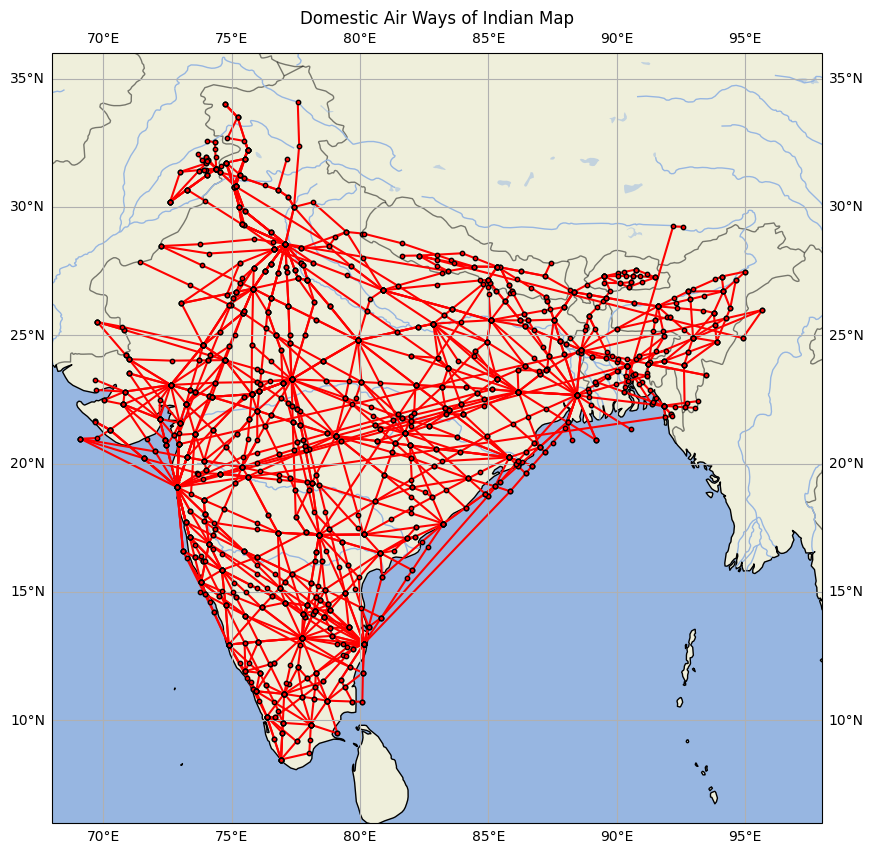

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and an axes object with the specified projection
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add Indian boundaries and states
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([68, 98, 6, 36], crs=ccrs.PlateCarree())

# Scatter plot on the map
# Example latitude and longitude data
for route in routes.index.unique().values:
    try : 
        latitudes = routes.loc[route]['latitude'].values 
        longitudes = routes.loc[route]['longitude'].values
    except : 
        latitudes =  [routes.loc[route]['latitude']]
        longitudes = [routes.loc[route]['longitude']]
    ax.scatter(longitudes, latitudes, color='red', s=10, edgecolor='k', zorder=5)
    ax.plot(longitudes, latitudes, color='red')

# Add gridlines for better readability
ax.gridlines(draw_labels=True)

# Add title
plt.title('Domestic Air Ways of Indian Map')
plt.savefig("DomesticAirWays.png")
# Show the plot
plt.show()

In [5]:
edge_list = []

for route in routes.index.unique().values:
    edge = [] 
    for node in routes.loc[route].iterrows():
        edge.append(node[1].node)
        # print(edge)
        if len(edge) == 2 :
            edge_list.append(edge.copy())
            del edge[0]
print(f'Number of edges in graph : {len(edge_list)}')

Number of edges in graph : 1495


In [7]:
def create_adjacency_graph(edge_list):
  """
  Creates an adjacency graph represented as a dictionary of sets from an edge list.

  Args:
      edge_list: A list of tuples where each tuple represents an edge (source, destination).

  Returns:
      A dictionary where keys are nodes and values are sets of their connected nodes.
  """
  graph = {}
  for source, destination in edge_list:
    if source not in graph:
      graph[source] = set()
    graph[source].add(destination)

    if destination not in graph:
      graph[destination] = set()
    graph[destination].add(source)  
  return graph

In [8]:
graph = create_adjacency_graph(edge_list)

In [23]:
import heapq
from math import  sqrt

def a_star_search(graph, source, destination, max_paths=3):
  """
  Performs A* search to find the best (shortest hop count) paths between source and destination.

  Args:
      graph: Adjacency graph represented as a dictionary of sets.
      source: Starting node of the search.
      destination: Destination node of the search.
      max_paths: Maximum number of paths to return (default: 3).

  Returns:
      A list containing the best max_paths paths (in terms of hop count) or an empty list if no path is found.
  """

  # Priority queue for storing frontier nodes (ordered by f-score)
  frontier = [(0, source, [])]  # (f-score, current node, path to reach current node)

  # Set to store visited nodes
  visited = set()
  results = [] 
  while frontier:
    # Get the node with the lowest f-score from the frontier
    f_score, current_node, path = heapq.heappop(frontier)

    # If the destination is reached, add the path to results and potentially stop
    if current_node == destination:
      path.append(current_node)
      results.append(path)
      if len(results) == max_paths:
        return results

    # Mark current node as visited
    visited.add(current_node)

    # Explore neighbors
    for neighbor in graph[current_node]:
      if neighbor not in visited:
        # Calculate g-score (hop count) for the neighbor
        g_score = len(path) + 1

        # Heuristic function (assuming distance to destination is known for each node)
        h_score = 0 # haversine_heuristic(navigationalId_map[source],navigationalId_map[neighbor], navigationalId_map[destination])

        # Calculate f-score (g_score + h_score)
        total_f_score = g_score + h_score

        # Add neighbor to the frontier with its f-score, path, and g-score
        heapq.heappush(frontier, (total_f_score, neighbor, path + [current_node]))

  return results  # No path found


def euclidean_heuristic(source_coords, neighbor_coords, destination_coords):
  """
  Calculates the straight-line (Euclidean) distance estimate between two points.

  Args:
      source_coords: Tuple containing latitude and longitude of the source node.
      neighbor_coords: Tuple containing latitude and longitude of the neighbor node.
      destination_coords: Tuple containing latitude and longitude of the destination node.

  Returns:
      Estimated straight-line distance between the neighbor and the destination.
  """

  # Unpack coordinates for readability
  source_x, source_y = source_coords
  neighbor_x, neighbor_y = neighbor_coords
  destination_x, destination_y = destination_coords

  # Calculate the squared differences in coordinates
  x_diff_squared = (destination_x - neighbor_x) ** 2
  y_diff_squared = (destination_y - neighbor_y) ** 2

  # Calculate the Euclidean distance (straight line)
  distance = sqrt(x_diff_squared + y_diff_squared)

  return distance

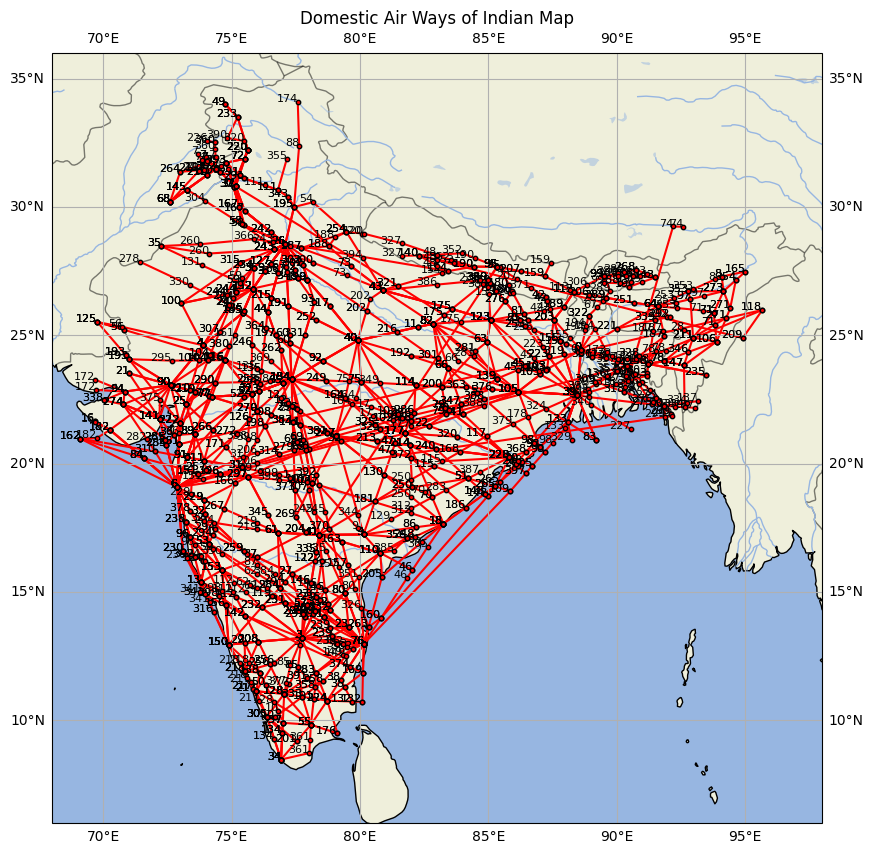

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add Indian boundaries and states
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([68, 98, 6, 36], crs=ccrs.PlateCarree())

# Scatter plot on the map with labels
# Example latitude and longitude data
for route in routes.index.unique().values:
    try:
        latitudes = routes.loc[route]['latitude'].values
        longitudes = routes.loc[route]['longitude'].values
        names = routes.loc[route]['node'].values
    except:
        latitudes = [routes.loc[route]['latitude']]
        longitudes = [routes.loc[route]['longitude']]
        names = [routes.loc[route]['node']]
    
    ax.scatter(longitudes, latitudes, color='red', s=10, edgecolor='k', zorder=5)
    ax.plot(longitudes, latitudes, color='red')
    
    for lon, lat, name in zip(longitudes, latitudes, names):
        ax.text(lon, lat, name, fontsize=8, ha='right', transform=ccrs.PlateCarree())

# Add gridlines for better readability
ax.gridlines(draw_labels=True)

# Add title
plt.title('Domestic Air Ways of Indian Map')
# Show the plot
plt.show()

In [25]:
a_star_search(graph,263 , 172 , max_paths=10)

[[263, 76, 284, 61, 345, 297, 31, 171, 272],
 [263, 76, 284, 61, 345, 297, 31, 311, 272],
 [263, 205, 110, 9, 107, 399, 31, 171, 272],
 [263, 205, 110, 9, 107, 399, 31, 311, 272],
 [263, 76, 231, 62, 53, 32, 6, 31, 171, 272],
 [263, 76, 231, 62, 53, 96, 6, 31, 171, 272],
 [263, 76, 231, 62, 53, 238, 6, 31, 171, 272],
 [263, 76, 231, 62, 53, 378, 6, 31, 171, 272],
 [263, 76, 231, 62, 153, 96, 6, 31, 171, 272],
 [263, 76, 284, 61, 345, 297, 31, 398, 126, 272]]

In [26]:
navigationalId_map = {} 

navigationalId_map = {}

for route in routes.values: 
    # print(route[6])
    if route[4] not in navigationalId_map : 
        navigationalId_map[route[4]] = (route[5] , route[6])
        pass

print(navigationalId_map)

{43: (26.758556, 80.894417), 175: (25.886984, 83.54472185714285), 123: (25.590417, 85.089917), 255: (25.405833666666663, 86.530602), 155: (24.769523714285715, 87.91980171428573), 0: (24.410945636363635, 88.60022245454546), 14: (23.8487436, 90.4130187), 158: (23.899769125, 91.245460125), 235: (23.450833, 93.463333), 116: (24.035555375, 74.7367015), 104: (24.08202385714286, 73.99912714285713), 56: (25.25944433333333, 70.779722), 125: (25.520092, 69.770906), 6: (19.086169, 72.874703), 261: (20.757972, 72.946303), 222: (21.583889, 72.982778), 25: (22.332972, 73.225056), 210: (22.81821442857143, 73.49710328571427), 4: (24.612842, 73.894111), 24: (26.1871666, 74.93177800000001), 234: (27.6375, 75.864167), 243: (28.386632, 76.655208375), 26: (28.566917, 77.093528), 362: (31.499722, 74.400019), 277: (31.592222, 74.580833), 393: (31.728031, 74.785911), 39: (22.675972, 88.44813900000001), 395: (22.77083333333333, 88.92703733333333), 309: (23.168123666666663, 89.17322033333333), 136: (23.404064, 

In [27]:
def plot_paths(src , des ,npaths=3):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add Indian boundaries and states
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.set_extent([68, 98, 6, 36], crs=ccrs.PlateCarree())

    # Scatter plot on the map
    # Example latitude and longitude data
    routes = a_star_search(graph , src , des , max_paths=npaths) 
    print()
    for route in routes:
        try : 
            latitudes = [navigationalId_map[node][0] for node in route]  
            longitudes = [navigationalId_map[node][1] for node in route]  
        except Exception as e:
            print(e) 
            # latitudes =  [i.loc[route]['latitude']]
            # longitudes = [i.loc[route]['longitude']]
        ax.scatter(longitudes, latitudes, color='red', s=10, edgecolor='k', zorder=5)
        ax.plot(longitudes, latitudes, color='red')

    # Add gridlines for better readability
    ax.gridlines(draw_labels=True)

    # Add title
    plt.title('Domestic Air Ways of Indian Map')
    # plt.savefig("DomesticAirWays.png")
    # Show the plot
    plt.show()

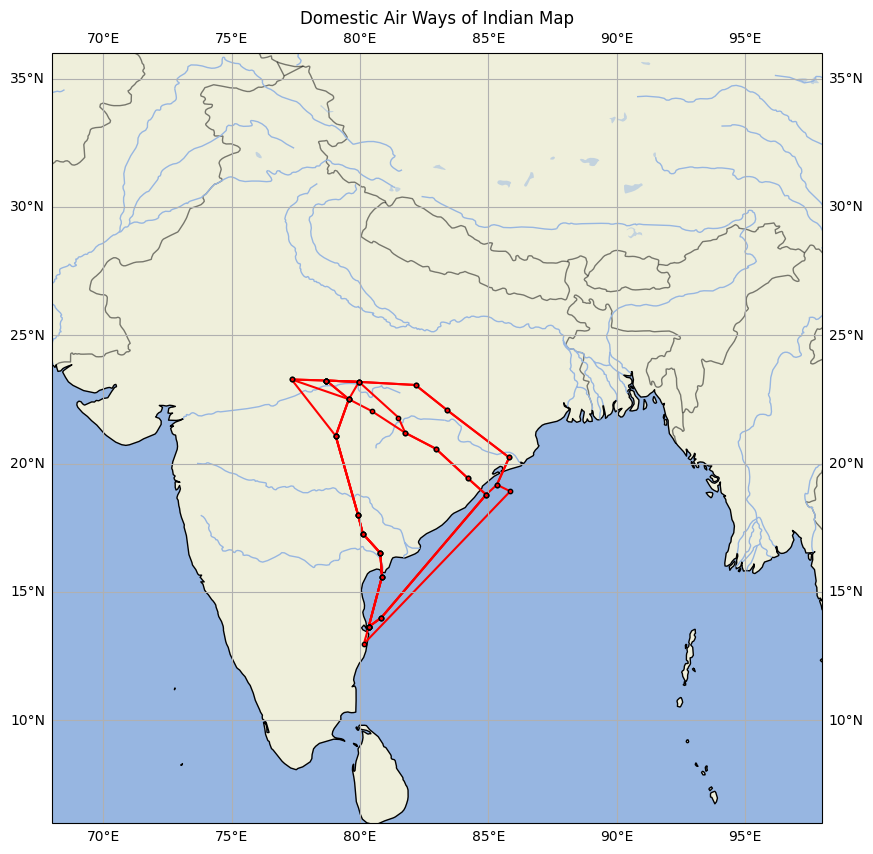

In [33]:
plot_paths(263 ,249 , npaths=30)

In [35]:
from heapq import nsmallest


def euclidean_distance(lat1, lon1, lat2, lon2):
    return sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)

def find_nearest_coordinates(coords, target_lat, target_lon, n=3):
    distances = {}
    
    for key, (lat, lon) in coords.items():
        distance = euclidean_distance(target_lat, target_lon, lat, lon)
        distances[key] = distance
    
    nearest_keys = nsmallest(n, distances, key=distances.get)
    
    return nearest_keys


In [39]:
target_lat = 13.0 # chennai
target_lon = 80.0
nearest_coords_src = find_nearest_coordinates(navigationalId_map, target_lat, target_lon , n =5)

print(nearest_coords_src)

[76, 382, 263, 149, 23]


In [38]:
target_lat = 19 # mumbai 
target_lon = 72

nearest_coords_des = find_nearest_coordinates(navigationalId_map, target_lat, target_lon , n =5)

print(nearest_coords_des)

[6, 84, 310, 378, 238]


In [67]:
def find_multiple_paths(src , des) :
    lat , long = src 
    src_nodes = find_nearest_coordinates(navigationalId_map, lat, long , n =5)
    lat , long = des
    des_nodes = find_nearest_coordinates(navigationalId_map, lat, long , n =5)
    paths = [] 
    for src_node in src_nodes :
        for des_node in des_nodes :
            paths.extend(a_star_search(graph ,src_node , des_node ,max_paths=3))
    return paths



In [68]:
find_multiple_paths((13,80),(19,72))

[[76, 231, 62, 53, 32, 6],
 [76, 231, 62, 53, 96, 6],
 [76, 231, 62, 53, 238, 6],
 [76, 231, 62, 53, 32, 6, 84],
 [76, 231, 62, 53, 96, 6, 84],
 [76, 231, 62, 53, 238, 6, 84],
 [76, 231, 62, 53, 32, 6, 310],
 [76, 231, 62, 53, 96, 6, 310],
 [76, 231, 62, 53, 238, 6, 310],
 [76, 231, 62, 53, 378],
 [76, 284, 62, 53, 378],
 [76, 231, 62, 53, 32, 378],
 [76, 231, 62, 53, 238],
 [76, 284, 62, 53, 238],
 [76, 231, 62, 53, 96, 238],
 [382, 76, 231, 62, 53, 32, 6],
 [382, 76, 231, 62, 53, 96, 6],
 [382, 76, 231, 62, 53, 238, 6],
 [382, 76, 231, 62, 53, 32, 6, 84],
 [382, 76, 231, 62, 53, 96, 6, 84],
 [382, 76, 231, 62, 53, 238, 6, 84],
 [382, 76, 231, 62, 53, 32, 6, 310],
 [382, 76, 231, 62, 53, 96, 6, 310],
 [382, 76, 231, 62, 53, 238, 6, 310],
 [382, 76, 231, 62, 53, 378],
 [382, 76, 284, 62, 53, 378],
 [382, 293, 231, 62, 53, 378],
 [382, 76, 231, 62, 53, 238],
 [382, 76, 284, 62, 53, 238],
 [382, 293, 61, 219, 294, 238],
 [263, 76, 231, 62, 53, 32, 6],
 [263, 76, 231, 62, 53, 96, 6],
 [26

In [69]:
def remove_overlapping_paths(paths):
  """
  Removes repetitive or overlapping paths from a list of lists.

  Args:
      paths: A list of lists, where each inner list represents a path (sequence of points).

  Returns:
      A new list of lists containing only unique, non-overlapping paths.
  """

  unique_paths = []
  seen_prefixes = set()  # Set to store seen prefixes for faster comparison

  for path in paths:
    is_unique = True
    # Check for complete overlap with previously seen paths
    for i in range(len(path)):
      prefix = tuple(path[:i])
      if prefix in seen_prefixes:
        is_unique = False
        break
      seen_prefixes.add(prefix)

    # Check for tail overlap only if the path is still considered unique
    if is_unique:
      tail = tuple(path[-1:])
      if tail in seen_tails:
        is_unique = False
      else:
        seen_tails.add(tail)

    if is_unique:
      unique_paths.append(path)

  return unique_paths

# Initialize set to store seen tails (optional but improves efficiency)
seen_tails = set()

# Example usage
paths = [
    [1, 2, 3, 4],
    [1, 2, 4],
    [1, 2, 3],
    [5, 6, 7],
    [2, 3, 4, 5],  # Overlaps with [1, 2, 3, 4] after index 2
]

unique_paths = remove_overlapping_paths(find_multiple_paths((13,80),(19,72)))

print("Original paths:", find_multiple_paths((13,80),(19,72)))
print("Unique paths (no overlaps):", unique_paths)


Original paths: [[76, 231, 62, 53, 32, 6], [76, 231, 62, 53, 96, 6], [76, 231, 62, 53, 238, 6], [76, 231, 62, 53, 32, 6, 84], [76, 231, 62, 53, 96, 6, 84], [76, 231, 62, 53, 238, 6, 84], [76, 231, 62, 53, 32, 6, 310], [76, 231, 62, 53, 96, 6, 310], [76, 231, 62, 53, 238, 6, 310], [76, 231, 62, 53, 378], [76, 284, 62, 53, 378], [76, 231, 62, 53, 32, 378], [76, 231, 62, 53, 238], [76, 284, 62, 53, 238], [76, 231, 62, 53, 96, 238], [382, 76, 231, 62, 53, 32, 6], [382, 76, 231, 62, 53, 96, 6], [382, 76, 231, 62, 53, 238, 6], [382, 76, 231, 62, 53, 32, 6, 84], [382, 76, 231, 62, 53, 96, 6, 84], [382, 76, 231, 62, 53, 238, 6, 84], [382, 76, 231, 62, 53, 32, 6, 310], [382, 76, 231, 62, 53, 96, 6, 310], [382, 76, 231, 62, 53, 238, 6, 310], [382, 76, 231, 62, 53, 378], [382, 76, 284, 62, 53, 378], [382, 293, 231, 62, 53, 378], [382, 76, 231, 62, 53, 238], [382, 76, 284, 62, 53, 238], [382, 293, 61, 219, 294, 238], [263, 76, 231, 62, 53, 32, 6], [263, 76, 231, 62, 53, 96, 6], [263, 76, 231, 62, 

In [70]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import numpy as np

def plot_routes(routes):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add Indian boundaries and states
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.set_extent([68, 98, 6, 36], crs=ccrs.PlateCarree())

    # Generate a colormap
    colormap = plt.get_cmap('tab20', len(routes))

    # Scatter plot on the map
    for i, route in enumerate(routes):
        try: 
            latitudes = [navigationalId_map[node][0] for node in route]  
            longitudes = [navigationalId_map[node][1] for node in route]  
        except Exception as e:
            print(e) 

        # Select color for the current route
        color = colormap(i)

        ax.scatter(longitudes, latitudes, color=color, s=10, edgecolor='k', zorder=5)
        ax.plot(longitudes, latitudes, color=color, label=f'Route {i+1}')

    # Add gridlines for better readability
    ax.gridlines(draw_labels=True)

    # Add title and legend
    plt.title('Domestic Air Ways of Indian Map')
    plt.legend(loc='upper left')

    # Show the plot
    plt.show()


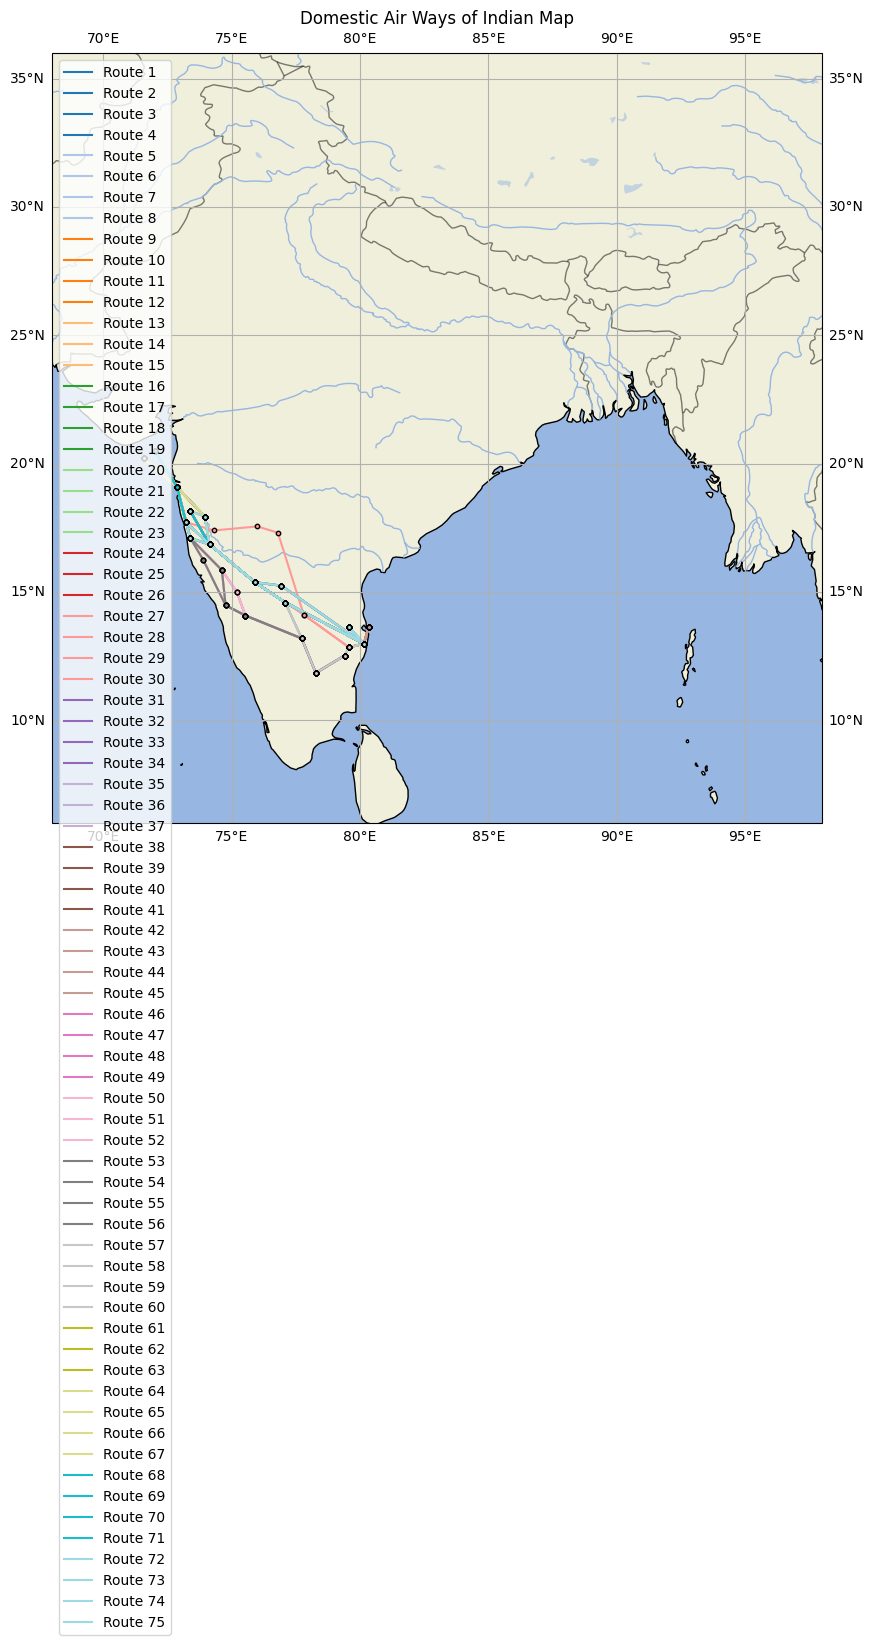

In [71]:
plot_routes(find_multiple_paths((13,80),(19,72)))

### With Heuristic 

In [ ]:
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 13,
	"longitude": 80,
	"hourly": ["temperature_2m", "rain", "showers", "snowfall", "weather_code", "cloud_cover"]
}


In [65]:
import heapq
from math import  sqrt

def a_star_euclidean(graph, source, destination, max_paths=3):
  """
  Performs A* search to find the best (shortest hop count) paths between source and destination.

  Args:
      graph: Adjacency graph represented as a dictionary of sets.
      source: Starting node of the search.
      destination: Destination node of the search.
      max_paths: Maximum number of paths to return (default: 3).

  Returns:
      A list containing the best max_paths paths (in terms of hop count) or an empty list if no path is found.
  """

  # Priority queue for storing frontier nodes (ordered by f-score)
  frontier = [(0, source, [])]  # (f-score, current node, path to reach current node)

  # Set to store visited nodes
  visited = set()
  results = [] 
  while frontier:
    # Get the node with the lowest f-score from the frontier
    f_score, current_node, path = heapq.heappop(frontier)

    # If the destination is reached, add the path to results and potentially stop
    if current_node == destination:
      path.append(current_node)
      results.append(path)
      if len(results) == max_paths:
        return results

    # Mark current node as visited
    visited.add(current_node)

    # Explore neighbors
    for neighbor in graph[current_node]:
      if neighbor not in visited:
        # Calculate g-score (hop count) for the neighbor
        g_score = len(path) + 1

        # Heuristic function (assuming distance to destination is known for each node)
        h_score = euclidean_heuristic(navigationalId_map[neighbor] , navigationalId_map[destination])
        # Calculate f-score (g_score + h_score)
        total_f_score = g_score + h_score

        # Add neighbor to the frontier with its f-score, path, and g-score
        heapq.heappush(frontier, (total_f_score, neighbor, path + [current_node]))

  return results  # No path found


def euclidean_heuristic(source_coords , destination_coords):
  """
  Calculates the straight-line (Euclidean) distance estimate between two points.

  Args:
      source_coords: Tuple containing latitude and longitude of the source node.
      neighbor_coords: Tuple containing latitude and longitude of the neighbor node.
      destination_coords: Tuple containing latitude and longitude of the destination node.

  Returns:
      Estimated straight-line distance between the neighbor and the destination.
  """

  # Unpack coordinates for readability
  neighbor_x, neighbor_y = source_coords
  destination_x, destination_y = destination_coords

  # Calculate the squared differences in coordinates
  x_diff_squared = (destination_x - neighbor_x) ** 2
  y_diff_squared = (destination_y - neighbor_y) ** 2

  # Calculate the Euclidean distance (straight line)
  distance = sqrt(x_diff_squared + y_diff_squared)

  return distance

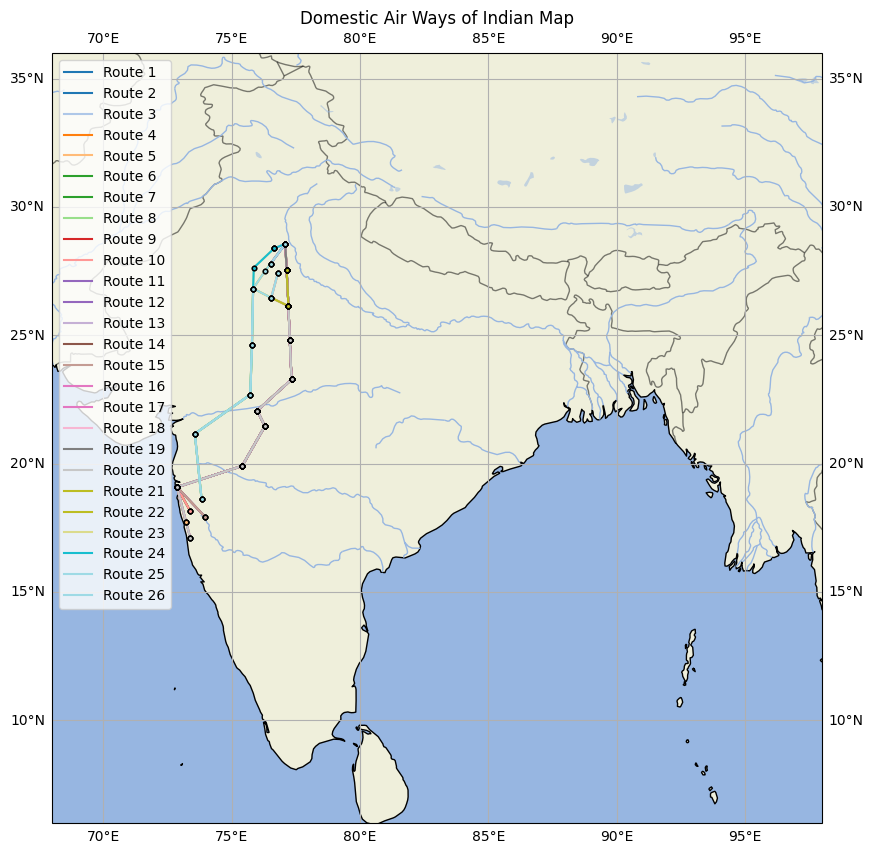

In [77]:
def find_multiple_paths(src , des) :
    lat , long = src 
    src_nodes = find_nearest_coordinates(navigationalId_map, lat, long , n =5)
    lat , long = des
    des_nodes = find_nearest_coordinates(navigationalId_map, lat, long , n =5)
    paths = [] 
    for src_node in src_nodes :
        for des_node in des_nodes :
            paths.extend(a_star_euclidean(graph ,src_node , des_node ,max_paths=3))
    return paths

plot_routes(find_multiple_paths((18,73),(28,77)))

In [75]:
a_star_euclidean(graph,76,21)

[[76, 284, 61, 345, 297, 31, 91, 89, 25, 90, 21]]